In [2]:
from spectral import *
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import h5py
import pandas as pd

In [ ]:
# Define files
path_snapshot1 = "data/Snapshot/leafs_processed_allcorrections_processed/leafs_comparison/"
path_snapshot2 = "data/Snapshot/leafs_comparison_processed/leafs_comparison/"
path_hrhsi = "data/HrHSI/FX10_test/"

data_snapshot1 = envi.open(path_snapshot1 + "image_0000000000.hdr", path_snapshot1 + "image_0000000000.raw")
data_snapshot2 = envi.open(path_snapshot2 + "image_0000000000.hdr", path_snapshot2 + "image_0000000000.raw")

data_snapshot1_nparr = np.array(data_snapshot1.load())
data_snapshot2_nparr = np.array(data_snapshot2.load())

# imshow(data_snapshot1_nparr)
# imshow(data_snapshot2_nparr)

In [ ]:
img_snapshot = open_image(path_snapshot1 + "image_0000000000.hdr")
print(img_snapshot)


img_hrhsi = open_image(path_hrhsi + "haver_0.hdf5")

## Load hrHSI file

<Axes: xlabel='value (<undefined>)', ylabel='Intensity'>

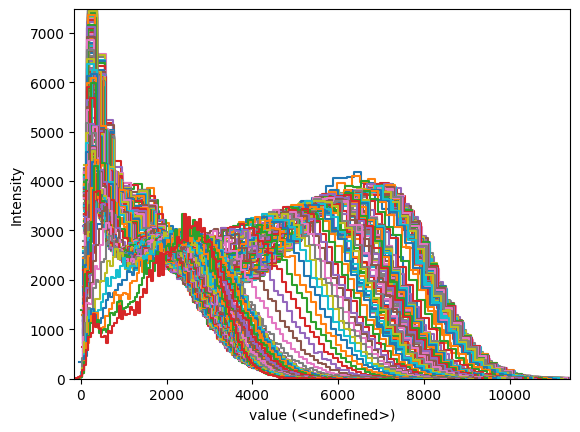

In [79]:
path_hrhsi = "data/HrHSI/FX17_test/"
f_haver = h5py.File(path_hrhsi + "haver_3.hdf5", "r")
f_rogge = h5py.File(path_hrhsi + "rogge_0.hdf5", "r")

img_haver = hs.signals.Signal2D(f_haver["hypercube"])
# img_haver.plot(colorbar=True, scalebar=False, 
#                axes_ticks=True, cmap="viridis")



img_rogge = hs.signals.Signal2D(f_rogge["hypercube"])
# img_rogge.plot(colorbar=True, scalebar=False, 
#                axes_ticks=True, cmap="viridis")

hs.plot.plot_histograms(img_haver, legend=None)

# ims = hs.signals.Signal2D([f_haver["hypercube"], f_rogge["hypercube"]])
# ims.plot.plot_images(colorbar=True, scalebar=False, 
#                axes_ticks=True, cmap="viridis")


In [56]:
data_hrhsi = f_haver.get("hypercube")
np_array_hrhsi = np.array(data_hrhsi)
print(np_array_hrhsi.shape)

(224, 320, 440)


## Load Snapshot file

In [75]:
path_snapshot = "data/Snapshot/leafs_processed_allcorrections_processed/leafs_comparison/"
# img_snap = envi.open(path_snapshot + "image_0000000000.hdr", path_snapshot + "image_0000000000.raw")

# path_snapshot = "data/Snapshot/leafs_comparison_unprocessed/leafs_comparison/"
img_snap = envi.open(path_snapshot + "image_0000000000.hdr", path_snapshot + "image_0000000000.raw")

# img_snapshot = hs.load(path_snapshot + "image_0000000000.raw")


np_array_snap = img_snap.load()

np_array_snap = np.array(img_snap.load())
print(np_array_snap.shape)


(214, 407, 25)


In [78]:
# Specify dimensions
width = 407
height = 214
bands = 25

raw_data = np.fromfile(path_snapshot + "image_0000000000.raw", dtype=np.uint16)
raw_data = raw_data.reshape((height, width, bands))

ValueError: cannot reshape array of size 4354900 into shape (214,407,25)